In [2]:
import importlib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.utils import gen_batches
import numpy as np
from Code.SGDPLS import SGDPLS
from Code.OLPLS import OLPLS
from Code.CIPLS import CIPLS
from Code.SIMPLS import SIMPLS
from Code.IPLS import IPLS
from Code.PLS1 import IPLS1
import h5py
# ----------
import seaborn as sns
from sklearn.metrics import root_mean_squared_error as RMSE
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from pytictoc import TicToc
tim=TicToc()

In [3]:
dataset='CTSlices'
CT_dat = np.genfromtxt("data/CTSlices/slice_localization_data.csv",
                       delimiter=",",
                       skip_header=1)
X_train = CT_dat[:,1:-1]
y_train = CT_dat[:,-1]

In [4]:
n_train = X_train.shape[0]
batch_size = 100
batch_num = int(n_train/batch_size)
print(f"n_train: {n_train:d}; batch_num: {batch_num:d}, batch_size: {batch_size:d}")

# batches = gen_batches(n_train, batch_size)
train_ind = slice((None, n_train))
trainset = [ slice((i+1)*batch_size) for i in range(batch_num)]
samples = [(i+1)*batch_size for i in range(batch_num)]

n_train: 53500; batch_num: 535, batch_size: 100


In [8]:
def RunExp(method, PLS, case, save):
    tim = TicToc()
    timlist=np.zeros((2, len(trainset)))
    timlist[0] = np.array(samples)
    if (case==1):
        for i,s in enumerate(gen_batches(n_train, batch_size)):
            tim.tic()
            PLS.fit(X_train[s], y_train[s])
            timlist[1,i] = tim.tocvalue()
    else:
        for i,s in enumerate(trainset):
            tim.tic()
            PLS.fit(X_train[s], y_train[s])
            timlist[1,i] = tim.tocvalue()

    if ((method == 'SIMPLS') |
        (method == 'OLPLS')):
        PLS._comp_coef(PLS.n_components)
        coef  = PLS.coef_
    elif(method != 'NIPALS'):
        PLS._comp_coef()
        coef  = PLS.coef_
    else:
        coef  = PLS.coef_.ravel()

    if (save==1):
        with h5py.File(f"./Results/PLS1_CTSlices_{method}.h5", "w") as f:
            f_coef = f.create_dataset('coef', data=coef, maxshape=coef.shape, chunks=True)
            f_tim = f.create_dataset('timer', data=timlist, maxshape=timlist.shape, chunks=True)


In [6]:
def Read_Results(method, case):
    with h5py.File(f"./Results/PLS1_CTSlices_{method}.h5", "r") as f:
        dat={'timer': f['timer'][:],
             'coef':  f['coef'][:]}
    return dat

def timer_stats(method, timer):
    print(f"{method:s} timer\n"
      + f"  Ave: {np.mean(timer):.4f}\n"
      + f"  Std: {np.std(timer):.4f}")

In [5]:
from sklearn.cross_decomposition import PLSRegression

save=1
tim.tic()
PLS = PLSRegression(n_components=9, scale=False)
RunExp('NIPALS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 316.44085395429283


In [10]:
import Code.OLPLS
importlib.reload(Code.OLPLS)
from Code.OLPLS import OLPLS

save=1
tim.tic()
PLS = OLPLS(n_components=4, amnesic=0.72, mu=1.9041e-6)
RunExp('OLPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 46.34111330471933


In [12]:
import Code.SGDPLS
importlib.reload(Code.SGDPLS)
from Code.SGDPLS import SGDPLS

save=1
tim.tic()
PLS = SGDPLS(n_components=2, eta=1.7549e-7)
RunExp('SGDPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 275.17769530788064


In [7]:
import Code.CIPLS
importlib.reload(Code.CIPLS)
from Code.CIPLS import CIPLS

save=1
tim.tic()
PLS = CIPLS(n_components=1)
RunExp('CIPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 22.71359130181372


In [7]:
import Code.PLS1
importlib.reload(Code.PLS1)
from Code.PLS1 import PLS1

save=1
tim.tic()
PLS= PLS1(n_components=9)
RunExp('PLS1', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 74.71643773140386


In [14]:
import Code.PLS1
importlib.reload(Code.PLS1)
from Code.PLS1 import IPLS1

save=1
tim.tic()
PLS= IPLS1(n_components=9)
RunExp('IPLS1', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 2.0642851940356195


In [15]:
import Code.SIMPLS
importlib.reload(Code.SIMPLS)
from Code.SIMPLS import SIMPLS

save=1
tim.tic()
PLS = SIMPLS(n_components=9)
RunExp('SIMPLS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 75.32259857747704


In [16]:
import Code.ISIMPLS
importlib.reload(Code.ISIMPLS)
from Code.ISIMPLS import ISIMPLS

save=1
tim.tic()
PLS= ISIMPLS(n_components=9)
RunExp('ISIMPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 2.1392061533406377


In [13]:
NIPALS  = Read_Results('NIPALS', 0)
OLPLS   = Read_Results('OLPLS', 1)
SGDPLS  = Read_Results('SGDPLS', 1)
CIPLS   = Read_Results('CIPLS', 0)
PLS1    = Read_Results('PLS1', 0)
IPLS1   = Read_Results('IPLS1', 1)
SIMPLS  = Read_Results('SIMPLS', 0)
ISIMPLS = Read_Results('ISIMPLS', 1)

print("NIPALS v.s. OLPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(NIPALS['coef'], OLPLS['coef'])) )
print("NIPALS v.s. SGDPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(NIPALS['coef'], SGDPLS['coef'])) )
print("NIPALS v.s. CIPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(NIPALS['coef'], CIPLS['coef'])) )
print("PLS1 v.s. IPLS1")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(PLS1['coef'], IPLS1['coef'])) )
print("SIMPLS v.s. ISIMPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(SIMPLS['coef'], ISIMPLS['coef'])))
print("\n")

timer_stats("NIPALS", NIPALS['timer'][1])
timer_stats("SIMPLS", SIMPLS['timer'][1])
timer_stats("PLS1", PLS1['timer'][1])

timer_stats("OLPLS", OLPLS['timer'][1])
timer_stats("SGDPLS", SGDPLS['timer'][1])
timer_stats("ISIMPLS", ISIMPLS['timer'][1])
timer_stats("IPLS1", IPLS1['timer'][1])
timer_stats("CIPLS", CIPLS['timer'][1])


NIPALS v.s. OLPLS
  RMSE of coef.:    1.6897201e+00
NIPALS v.s. SGDPLS
  RMSE of coef.:    5.3943201e+05
NIPALS v.s. CIPLS
  RMSE of coef.:    1.3119087e+00
PLS1 v.s. IPLS1
  RMSE of coef.:    1.7901466e-13
SIMPLS v.s. ISIMPLS
  RMSE of coef.:    2.9763151e-13


NIPALS timer
  Ave: 0.5915
  Std: 0.3583
SIMPLS timer
  Ave: 0.1408
  Std: 0.0833
PLS1 timer
  Ave: 0.1413
  Std: 0.0840
OLPLS timer
  Ave: 0.0866
  Std: 0.0069
SGDPLS timer
  Ave: 0.5143
  Std: 0.0169
ISIMPLS timer
  Ave: 0.0040
  Std: 0.0017
IPLS1 timer
  Ave: 0.0038
  Std: 0.0007
CIPLS timer
  Ave: 0.0424
  Std: 0.0010


<Figure size 640x480 with 0 Axes>

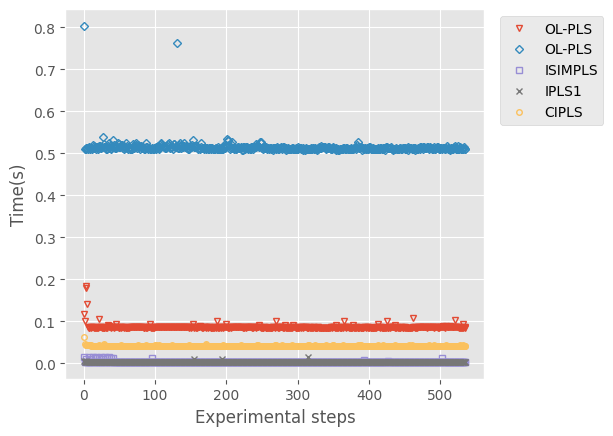

In [14]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), OLPLS['timer'][1],
                label='OL-PLS', ls='', marker='v', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SGDPLS['timer'][1],
                label='OL-PLS', ls='', marker='D', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPLS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), IPLS1['timer'][1],
                label='IPLS1', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), CIPLS['timer'][1],
                label='CIPLS', ls='', marker='o', markersize=ms, fillstyle='none')
 

ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/CTSlices_inc01.pdf')
# plt.close()

<Figure size 640x480 with 0 Axes>

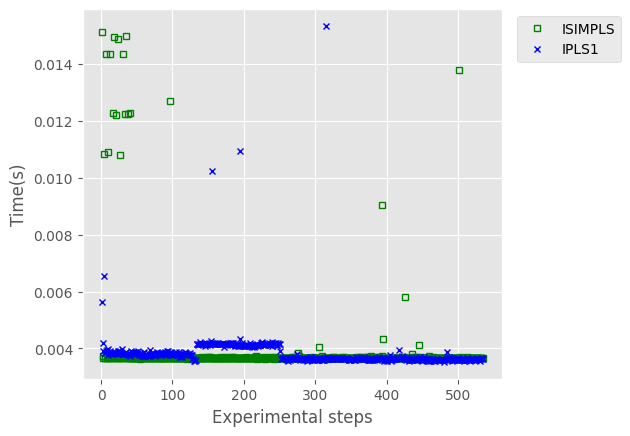

In [12]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPLS', ls='', marker='s', markersize=ms, fillstyle='none', color='green')
plt.plot(range(1,N_steps+1), IPLS1['timer'][1],
                label='IPLS1', ls='', marker='x', markersize=ms, fillstyle='none', color='blue')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/CTSlices_inc02.pdf')
# plt.close()

<Figure size 640x480 with 0 Axes>

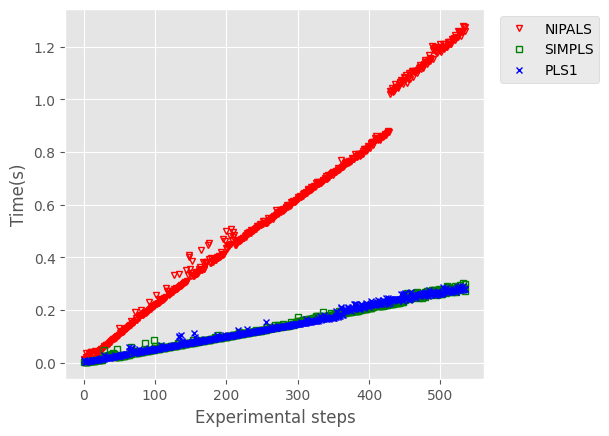

In [25]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), NIPALS['timer'][1],
                label='NIPALS', ls='', marker='v', markersize=ms, fillstyle='none', color='red')
plt.plot(range(1,N_steps+1), SIMPLS['timer'][1],
                label='SIMPLS', ls='', marker='s', markersize=ms, fillstyle='none', color='green')
plt.plot(range(1,N_steps+1), PLS1['timer'][1],
                label='PLS1', ls='', marker='x', markersize=ms, fillstyle='none', color='blue')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/CTSlices_full.pdf')
# plt.close()